In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from math import *
import time
import copy
import random
from matplotlib import animation
from IPython.display import HTML
import pandas as pd
import seaborn as sns
import matplotlib.pylab as pl

In [4]:
### RESETTING IMAGE RESOLUTION

umpp = 0.91 # um per pixel
time_i = 0 # initial time frame
time_f = 23 # final time frame
path = "Data/nov3_pad3_YFP/monoculture_nov3_pad3_22hr-02_s2t" # file name until timestamp
fc = "Cy3" # fluorescent channel name

nump = 50 # number of pixels to combine when resizing
dx = nump*umpp

dthr = 1 # time interval between frames in hr

# Import images

Phase = []
FC = []

t = time_i+1

im = np.array(Image.open(path+str(t).zfill(2)+".jpg").convert('L'))
Ly = len(im)
Lx = len(im[0])

Ly_new = int(Ly/nump)
Lx_new = int(Lx/nump)

size = Lx_new, Ly_new

def resolve_down(im, factor):
    Lx, Ly = im.size
    
    LR_off = Lx%factor
    L_off = int(LR_off/2)
    R_off = Lx-LR_off+L_off
    TB_off = Ly%factor
    T_off = int(TB_off/2)
    B_off = Ly-TB_off+T_off
    
    im1 = np.array(im.crop((L_off, T_off, R_off, B_off)))
    
    new = []
    for a in im1:
        b = a.reshape(-1, factor).mean(axis=1)
        new.append(b)
    new = np.array(new).T
    neww = []
    for a in new:
        b = a.reshape(-1, factor).mean(axis=1)
        neww.append(b)
    newww = np.array(neww).T
    
    return newww

while t<time_f:
    imp = Image.open(path+str(t).zfill(2)+"_Phase.jpg").convert('L')
    imp_resized = resolve_down(imp, nump)
    #imp_resized = np.array(imp.resize(size, Image.ANTIALIAS)).astype(np.float32)/
    imf = Image.open(path+str(t).zfill(2)+"_{}.jpg".format(fc)).convert('L')
    imf_resized = resolve_down(imf, nump)
    #imf_resized = np.array(imf.resize(size, Image.ANTIALIAS)).astype(np.float32)
    
    Phase.append(imp_resized)
    FC.append(imf_resized)
    t+=1
    
Phase = np.array(Phase)
FC = np.array(FC)

for i in range(len(Phase)):
    cut = 0.1 * np.max(FC[i])
    FC[i][FC[i] <= cut] = 0
    Phase[i][FC[i] <= cut] = 0

In [6]:
## MODEL FUNCTIONS

def nbr_sum(M):
    """Get the discrete Laplacian of matrix M"""
    L = np.roll(M, (0,-1), (0,1)) # right neighbor
    L += np.roll(M, (0,+1), (0,1)) # left neighbor
    L += np.roll(M, (-1,0), (0,1)) # top neighbor
    L += np.roll(M, (+1,0), (0,1)) # bottom neighbor
    
    return L

def discrete_laplacian(M):
    """Get the discrete Laplacian of matrix M"""
    L = -4*M
    L += nbr_sum(M)
    
    return L

def divide(M1,M2):
    """To divide two numpy arrays M1/M2 element-wise and avoide division by zero"""
    f = np.divide(M1, M2, out=np.zeros_like(M1), where=M2!=0)
    return f

def update(C, S, Parameters):
    
    k, mu, Rhf, Qhf, Phf, Y, Ks, DC, DS = tuple(Parameters)
    
    R = Rhf/(Rhf+C)
    Q = C/(Qhf+C)
    P = Phf/(Phf+C)
    
    M = mu*C*S/(Ks+S)
    Sdiff = res*DS*discrete_laplacian(S) - dt*M*R/Y
    Cdiff = dt*M*R + res*DC*(P*nbr_sum(M*Q) -M*Q*nbr_sum(P))
    
    C += Cdiff
    S += Sdiff
    # Remove negative values
    S[S < 0] = 0 
    
    # Reflecting boundaries
    
    C[0,:], S[0,:] = C[1,:], S[1,:]          # top
    C[-1,:], S[-1,:] = C[-2,:], S[-2,:] # bottom
    C[:,0], S[:,0] = C[:,1], S[:,1]         # left
    C[:,-1], S[:,-1] = C[:,-2], S[:,-2]  # right
                            
    return C, S

def get_error(Phase, FC, Parameters, min_sd):
    
    k = Parameters[0]
    # Initialize
    C = copy.deepcopy(FC[0])*k
    C -= threshold
    C[C<0]=0
    S = np.ones((Ly_new,Lx_new))

    # Simulate

    update_every = dthr*3600 # number of time steps after which data is stored
    C_time = []
    S_time = []

    start = time.time()

    for tt in range(T):
        if tt%update_every == 0:
            C_time.append(C.copy())
            S_time.append(S.copy())
        C, S = update(C, S, Parameters)

    stop = time.time()

    error = 0

    t = time_i

    while t<time_f-2:
        sd = 0.1*Phase[t]
        sd[sd<min_sd] = min_sd
        error += np.sum((C_time[t]-Phase[t])**2/sd**2)
        t+=1

    return(error)

In [7]:
### SIMULATION PARAMETERS
# threshold
threshold = 1 # number to subtract from all pixels of the image used as initial condition for simulation

# Time Resolution in sec
dt = 1
# Time steps
T = int((time_f-1)*dthr*3600)

res = dt/dx**2 

print("Simulation time is", dt*T, "seconds \n dt =", dt, "seconds")
print("dt / dx^2 = ", res)

Simulation time is 79200 seconds 
 dt = 1 seconds
dt / dx^2 =  0.0004830334500664171


In [8]:
Parameters_MLE = [3, 0.000993, 3024, 7.5, 1491, 9, 0.00109, 202100, 2.25]
Parameters_min = [2.7, 0.0000489, 291, 77, 173, 53, 0.001, 3178, 435]

Parameters_i = [1, 0.0001, 150, 150, 150, 70, 0.001, 2500, 300]
Parameters_f = [2.7, 0.00005, 167, 42, 34, 57, 0.0004, 2880, 288]

Parameters1 = [3.208704, 0.000078, 508.375268, 2.090176, 2.006798, 122.197926, 0.659979, 22788.124687, 3.098104]
Parameters2 = [3.411914, 0.000038, 902.940201, 1.587085, 6.722963, 45.634240, 0.000693, 9712.268561, 226.930852]

Parameters1 = [2.517074, 0.000062, 160.304716, 475.42633, 20.125338, 124.066225, 0.120188, 21875.332911, 7.704967]
Parameters2 = [2.619656, 0.000055, 138.782845, 26.887267, 48.453357, 64.400502, 0.000139, 2305.062533, 108.125981]
Parameters3 = [2.622640, 0.000050, 235.878120, 43.522273, 920.192846, 51.599240, 0.004691, 2521.330287, 148.708979]

Parameters = [2.61, 0.0000693, 164, 391, 9, 133, 0.24, 28295, 7.48]
Parameters_MLE = [2.59891250e+00, 5.69344726e-05, 1.17234968e+02, 2.74612936e+01, 2.01166046e+01, 4.26205520e+01, 1.68894986e-04, 2.65683859e+03, 1.09146821e+02]

In [9]:
C2 = copy.deepcopy(FC[0])*Parameters_MLE[0]
C2 -= threshold
C2[C2<0]=0
S2 = np.ones((Ly_new,Lx_new))

# Simulate

update_every = dthr*3600 # number of time steps after which data is stored
C2_time = []
S2_time = []

start = time.time()

for tt in range(T):
    if tt%update_every == 0:
        C2_time.append(C2.copy())
        S2_time.append(S2.copy())
    C2, S2 = update(C2, S2, Parameters_MLE)

stop = time.time()

In [13]:
get_error(Phase, FC, Parameters_MLE, 1)

4578774.279531412

In [14]:
get_error(Phase, FC, Parameters_min, 1)

9226729.47228815

In [15]:
get_error(Phase, FC, Parameters_MLE, 22.7)

450390.6822725788

In [16]:
get_error(Phase, FC, Parameters_min, 22.7)

64499.0983831964

In [10]:
min_sd = 21.7
C2err = []

t=0
while t<time_f-2:
    sd = 0.1*Phase[t]
    sd[sd<min_sd] = min_sd
    C2err.append((C2_time[t]-Phase[t])**2/sd**2)
    t+=1

In [11]:
C2err_time = []

t=0
while t<time_f-2:
    C2err_time.append(np.sum(C2err[t]))
    t+=1

Text(0.5, 0, 'Time')

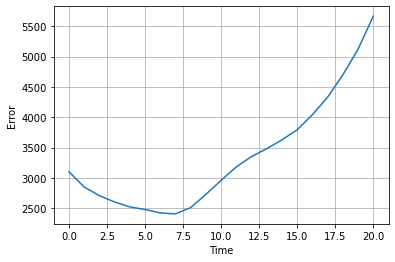

In [9]:
plt.plot(C2err_time)
plt.grid()
plt.ylabel("Error")
plt.xlabel("Time")

Text(0.5, 0, 'Time')

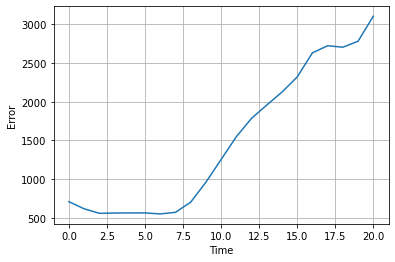

In [12]:
plt.plot(C2err_time)
plt.grid()
plt.ylabel("Error")
plt.xlabel("Time")

Text(0.5, 0, 'Time')

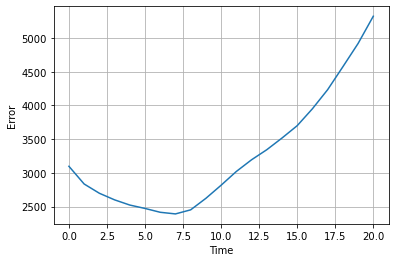

In [29]:
plt.plot(C2err_time)
plt.grid()
plt.ylabel("Error")
plt.xlabel("Time")

Text(0.5, 1.0, 't = 10')

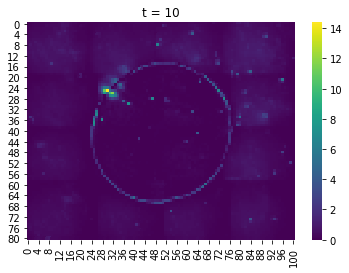

In [123]:
sns.heatmap(C2err[0], cmap='viridis')
plt.title("t = 10")

In [102]:
get_error(Phase, FC, Parameters_i, 22.7)

118889.75450726839

In [104]:
get_error(Phase, FC, Parameters_f, 22.7)

63514.83776500793

In [114]:
get_error(Phase, FC, Parameters, 22.7)

58318.74523559903

In [14]:
n = 22
colors = pl.cm.jet(np.linspace(0,1,n))

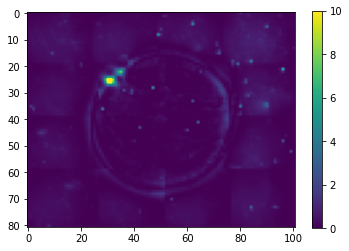

In [156]:
plt.imshow(C2err[8], vmin=0, vmax=10)
plt.colorbar()

Text(0.5, 0, 'x')

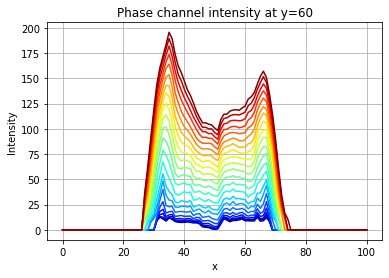

In [33]:
num = 0
for i in Phase:
    plt.plot(i[60], color=colors[num])
    num+=1
plt.grid()
plt.title('Phase channel intensity at y=60')
plt.ylabel("Intensity")
plt.xlabel("x")

Text(0.5, 0, 'x')

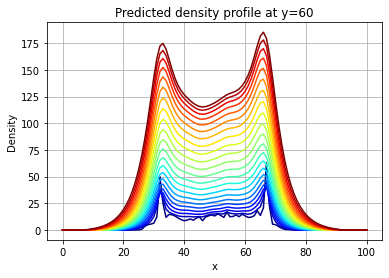

In [162]:
num = 0
for i in C2_time:
    plt.plot(i[60], color=colors[num])
    num+=1
plt.grid()
plt.title('Predicted density profile at y=60')
plt.ylabel("Density")
plt.xlabel("x")

Text(0.5, 0, 'x')

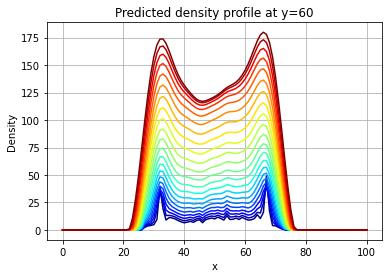

In [12]:
num = 0
for i in C2_time:
    plt.plot(i[60], color=colors[num])
    num+=1
plt.grid()
plt.title('Predicted density profile at y=60')
plt.ylabel("Density")
plt.xlabel("x")

Text(0.5, 0, 'x')

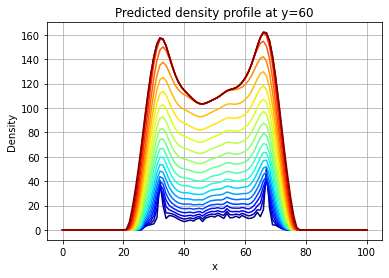

In [17]:
num = 0
for i in C2_time:
    plt.plot(i[60], color=colors[num])
    num+=1
plt.grid()
plt.title('Predicted density profile at y=60')
plt.ylabel("Density")
plt.xlabel("x")

Text(0.5, 0, 'x')

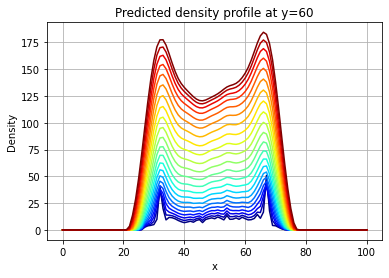

In [26]:
num = 0
for i in C2_time:
    plt.plot(i[60], color=colors[num])
    num+=1
plt.grid()
plt.title('Predicted density profile at y=60')
plt.ylabel("Density")
plt.xlabel("x")


Text(0.5, 0, 'x')

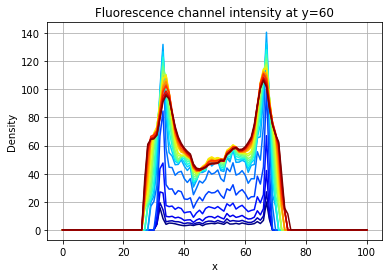

In [32]:
num = 0
for i in FC:
    plt.plot(i[60], color=colors[num])
    num+=1
plt.grid()
plt.title('Fluorescence channel intensity at y=60')
plt.ylabel("Density")
plt.xlabel("x")

Text(0.5, 0, 'x')

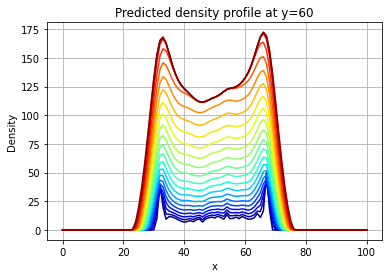

In [15]:
num = 0
for i in C2_time:
    plt.plot(i[60], color=colors[num])
    num+=1
plt.grid()
plt.title('Predicted density profile at y=60')
plt.ylabel("Density")
plt.xlabel("x")

In [177]:
import functions as fn

In [262]:
""" INPUT """
path = "Data/nov3_pad3_YFP/monoculture_nov3_pad3_22hr-02_s2t"  # file name until timestamp
fc = "Cy3"  # fluorescent channel name
time_i = 0  # initial time frame
time_f = 23  # final time frame
nump = 50  # number of pixels to combine when resizing
umpp = 0.91  # um per pixel
thresh_ph = 0  # background subtraction value for phase channel images
thresh_fl = 2.5  # background subtraction value for fluorescence channel images
dthr = 1  # time interval between frames in hr

input = [path, fc, time_i, time_f, nump, umpp, thresh_ph, thresh_fl, dthr]

Phase = []
FC = []

t = time_i+1
while t < time_f:
    imp = Image.open(path + str(t).zfill(2) + "_Phase.jpg").convert('L')
    imp_resized = resolve_down(imp, nump)
    imf = Image.open(path + str(t).zfill(2) + "_{}.jpg".format(fc)).convert('L')
    imf_resized = resolve_down(imf, nump)

    Phase.append(imp_resized)
    FC.append(imf_resized)
    t += 1

Phase = np.array(Phase)
FC = np.array(FC)
for i in range(len(Phase)):
    thresh = 0.1*np.max(FC[i])
    FC[i][FC[i]<= thresh] = 0
    Phase[i][FC[i]<= thresh] = 0

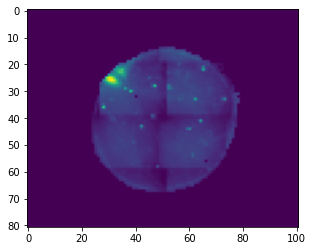

In [263]:
plt.imshow(Phase[0])

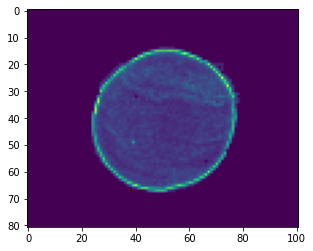

In [265]:
plt.imshow(FC[0])

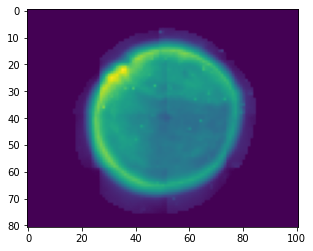

In [248]:
plt.imshow(Phase[19])

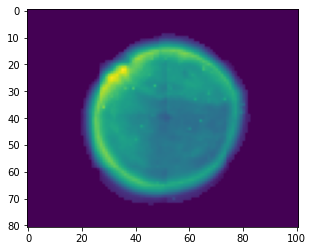

In [253]:
plt.imshow(Phase[19])

Text(0.5, 0, 'x')

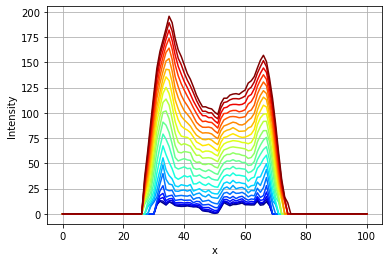

In [254]:
num = 0
for i in Phase:
    plt.plot(i[60], color=colors[num])
    num+=1
plt.grid()
plt.ylabel("Intensity")
plt.xlabel("x")

Text(0.5, 0, 'x')

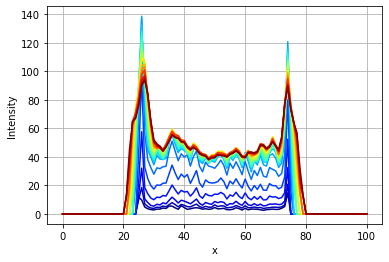

In [264]:
num = 0
for i in FC:
    plt.plot(i[50], color=colors[num])
    num+=1
plt.grid()
plt.ylabel("Intensity")
plt.xlabel("x")

In [224]:
vals = []
for i in Phase[0]:
    for j in i:
        vals.append(j)

In [231]:
""" INPUT """
path = "Data/nov3_pad3_YFP/monoculture_nov3_pad3_22hr-02_s2t"  # file name until timestamp
fc = "Cy3"  # fluorescent channel name
time_i = 0  # initial time frame
time_f = 23  # final time frame
nump = 50  # number of pixels to combine when resizing
umpp = 0.91  # um per pixel
thresh_ph = 0  # background subtraction value for phase channel images
thresh_fl = 2.5  # background subtraction value for fluorescence channel images
dthr = 1  # time interval between frames in hr

input = [path, fc, time_i, time_f, nump, umpp, thresh_ph, thresh_fl, dthr]

Phase = []
FC = []

t = time_i+1
while t < time_f:
    imp = Image.open(path + str(t).zfill(2) + "_Phase.jpg").convert('L')
    imp_resized = resolve_down(imp, nump)
    imf = Image.open(path + str(t).zfill(2) + "_{}.jpg".format(fc)).convert('L')
    imf_resized = resolve_down(imf, nump)

    Phase.append(imp_resized)
    FC.append(imf_resized)
    t += 1

Phase = np.array(Phase)
FC = np.array(FC)

thresh = 0.1*np.max(FC[0])

vals = []
for i in range(Phase[0].shape[0]):
    for j in range(Phase[0].shape[1]):
        if FC[0][i][j]<= thresh:
            vals.append(Phase[0][i][j])

In [266]:
vals = np.array(vals)
len(vals[vals<21.7])/len(vals)

0.9502640095384092